### Stance detection

### Stance detection for comparative question is the task consisting of determining, given a comparative question $Q$ between two objects $O_1$ and $O_2$ and an answer $A$, the stance of $A$ with respect to Q. The answer can either express:
- No stance;
- Neutrality;
- Being in favour of $O_1$;
- Being in favour of $O_2$.
### The paper "[LeviRANK: Limited Query Expansion with Voting Integration for Document Retrieval and Ranking](https://ceur-ws.org/Vol-3180/paper-259.pdf)" provides some results according to which, by splitting the task above in the two sub-tasks consisting of initially determining whether the stance is "No stance", "Neutrality" or "Being in favour of $O_x$" ($x \in \{1,2\}$) and then, if the last evaluation yielded "Being in favour of $O_x$", determining whether $x$ is $1$ or $2$.

# librerie usate: unire con quelle del notebook principale

In [1]:
!pip install transformers

In [78]:
from dataclasses import dataclass
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

In [3]:
@dataclass
class StanceConfig:
    DATASET_PATH = 'touche22-task2-stance-dataset.tsv'
    INIT_LR = 1e-5
    LR_REDUCTION_FACTOR_PLATEAU = .1
    MIN_LR = 1e-8
    MODEL_NNO_BATCH_SIZE = 16
    MODEL_OBJ_BATCH_SIZE = 16
    MODEL_NNO_CHECKPOINT_FOLDER = './model_nno_checkpoint/'
    MODEL_OBJ_CHECKPOINT_FOLDER = './model_obj_checkpoint/'
    MODEL_NNO_EPOCHS = 150
    MODEL_OBJ_EPOCHS = 150
    SEED = 42
    TRAIN_VAL_TEST_RATIOS = {'train': .8, 'val': .1, 'test': .1}

stance_config = StanceConfig()

#### Lettura del dataset

In [79]:
df = pd.read_csv(stance_config.DATASET_PATH, sep='\t')
df.head()

,ds,id,question,answer,answer_stance,answer_stance_object,object_count,object_1,mask_pos_1,object_2,mask_pos_2
0,softwareengineering.stackexchange,10373,What's the better way to charge for a cloud pl...,"Like all good questions, the answer depends. I...",2,simple but more expensive,2,simple but more expensive,"[[231, 252], [389, 393], [605, 619], [753, 757]]",complicated but cheaper,[]
1,softwareengineering.stackexchange,18838,Haskell AND Lisp vs. Haskell OR Lisp,"I suggest learning both, Haskell first, then C...",2,Haskell AND Lisp,2,Haskell AND Lisp,"[[25, 56]]",Haskell OR Lisp,[]
2,softwareengineering.stackexchange,19392,When is it better to offload work to the RDBMS...,You want to do all set-based operations in the...,3,do it in code,2,offload work to the RDBMS,"[[40, 55], [232, 248]]",do it in code,"[[165, 175], [578, 598]]"
3,softwareengineering.stackexchange,20653,Is it better to specialize in a single field I...,"Specialise if you enjoy it As you are aware, ...",3,expand into other fields to broaden my horizons,2,to specialize in a single field I like,"[[53, 63], [404, 410], [512, 519]]",expand into other fields to broaden my horizons,"[[892, 933]]"
4,softwareengineering.stackexchange,21186,Microsoft SDE Interview vs Microsoft SDET Inte...,"Unfortunately, those are both myths. SDEs and ...",1,Neutral,2,Microsoft SDE Interview,"[[37, 41], [283, 295], [950, 962]]",Microsoft SDET Interview,"[[46, 51], [341, 354], [832, 836], [938, 945]]"


#### For the current task, only the columns "question", "answer" and "answer_stance" are needed, since the aim of this section is to build a model able to tell the stance of the answer with respect to the asked question, as described. We also include the "dataset" column in order to be sure that we're hiding (as per license conditions) the records coming from the dataset kindly provided by Yahoo.

In [9]:
df = df.loc[:, ['ds','question','answer','answer_stance']]
df.head()

,ds,question,answer,answer_stance
0,softwareengineering.stackexchange,What's the better way to charge for a cloud pl...,"Like all good questions, the answer depends. I...",2
1,softwareengineering.stackexchange,Haskell AND Lisp vs. Haskell OR Lisp,"I suggest learning both, Haskell first, then C...",2
2,softwareengineering.stackexchange,When is it better to offload work to the RDBMS...,You want to do all set-based operations in the...,3
3,softwareengineering.stackexchange,Is it better to specialize in a single field I...,"Specialise if you enjoy it As you are aware, ...",3
4,softwareengineering.stackexchange,Microsoft SDE Interview vs Microsoft SDET Inte...,"Unfortunately, those are both myths. SDEs and ...",1


#### Now, we'll derive two dataset from this one:
- `df_nno`: used to train a network focused on determining whether the stance is "No stance", "Neutrality" or "Being in favour of $O_x$" ($x \in \{1,2\}$);
- `df_obj`: used to train a network focused on determining whether the stance is "Being in favour of $O_1$" or "Being in favour of $O_2$".
#### In particular, the first dataset will remove the distinction between `answer_stance` being equal to $2$ or $3$, the second dataset will consider ONLY the pairs (`question`, `answer`) whose `answer_stance` is either $2$ or $3$.

In [10]:
df_nno = df.copy()
df_obj = df.copy()

#The answer stances "Being in favour of O_1/2" must become indistinguishable from each other.
df_nno.loc[df_nno.answer_stance == 3, 'answer_stance'] = 2

#The only answer stances that we're considering are "Being in favour of O_1/2".
df_obj = df_obj.loc[df_obj.answer_stance.isin([2,3]),:]

#Remapping the answer stances "2" and "3" to, respectively, "0" and "1"
df_obj.answer_stance -= 2

#### Viewing the resulting DataFrames

In [11]:
df_nno.head()

,ds,question,answer,answer_stance
0,softwareengineering.stackexchange,What's the better way to charge for a cloud pl...,"Like all good questions, the answer depends. I...",2
1,softwareengineering.stackexchange,Haskell AND Lisp vs. Haskell OR Lisp,"I suggest learning both, Haskell first, then C...",2
2,softwareengineering.stackexchange,When is it better to offload work to the RDBMS...,You want to do all set-based operations in the...,2
3,softwareengineering.stackexchange,Is it better to specialize in a single field I...,"Specialise if you enjoy it As you are aware, ...",2
4,softwareengineering.stackexchange,Microsoft SDE Interview vs Microsoft SDET Inte...,"Unfortunately, those are both myths. SDEs and ...",1


In [12]:
df_obj.head()

,ds,question,answer,answer_stance
0,softwareengineering.stackexchange,What's the better way to charge for a cloud pl...,"Like all good questions, the answer depends. I...",0
1,softwareengineering.stackexchange,Haskell AND Lisp vs. Haskell OR Lisp,"I suggest learning both, Haskell first, then C...",0
2,softwareengineering.stackexchange,When is it better to offload work to the RDBMS...,You want to do all set-based operations in the...,1
3,softwareengineering.stackexchange,Is it better to specialize in a single field I...,"Specialise if you enjoy it As you are aware, ...",1
5,softwareengineering.stackexchange,How is IntelliJ better than Eclipse?,I work with Intellij (9.0.4 Ultimate) and Ecli...,0


#### Building the networks:

#### According to the aforementioned paper, a fine-tuned version of the *RoBERTA-Large-MNLI* is appropriate for the task of stance detection. For this reason, we chose to use a lighter model, originally fine-tuned on the same dataset: *distilbert-base-uncased-mnli* ([typeform/distilbert-base-uncased-mnli · Hugging Face](https://huggingface.co/typeform/distilbert-base-uncased-mnli)). Since the tasks are similar, but different, we load two variations of the previously hinted model, whose difference is just the head of the networks (some `Dense` layers that act as "Classification" layers), "re-assembled" in order to output either $2$ or $3$ values, depending on the number of needed classes.

#### Retrieving the tokenizer:

In [13]:
tokenizer = DistilBertTokenizer.from_pretrained("typeform/distilbert-base-uncased-mnli")

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

C:\Users\Andrea\anaconda3\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Andrea\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/258 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/776 [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


#### Retrieving the models:

In [14]:
model_nno = TFDistilBertForSequenceClassification.from_pretrained("typeform/distilbert-base-uncased-mnli", num_labels=3)
model_obj = TFDistilBertForSequenceClassification.from_pretrained("typeform/distilbert-base-uncased-mnli", num_labels=2, ignore_mismatched_sizes=True)

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at typeform/distilbert-base-uncased-mnli.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
Some layers from the model checkpoint at typeform/distilbert-base-uncased-mnli were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT ex

#### Looking at the models:

In [15]:
model_nno.summary()
model_obj.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,779
Trainable params: 66,955,779
Non-trainable params: 0
_________________________________________________________________
Model: "tf_distil_bert_for_sequence_classification_1"
________________________

#### We want to fine-tune the model, therefore we freeze the part of the network responsible of taking care of the *encoding* part of the process, and then we compile them.

#### Compiling the networks to prepare them for training (fine-tuning):

In [17]:
for model in [model_nno, model_obj]:
    model.distilbert.trainable = False
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(learning_rate = stance_config.INIT_LR),
        metrics=keras.metrics.SparseCategoricalAccuracy()
    )

#### Before proceeding, for reproducibility, we fix the random seeds.

In [18]:
def set_reproducibility(seed: int) -> None:
    """
    Fixes a given seed for the pseudo-random number generators.
    Args:
        seed (int): seed to fix
    """
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [19]:
set_reproducibility(stance_config.SEED)

#### Defining the train, val, test splits.

In [20]:
def train_val_test_splits(df: pd.DataFrame, ratios:dict) -> dict:
    """
    Splits a given DataFrame into train, val and test, according to the provided ratios.
    The dataframe is expected to contain the columns "question" and "answer". Other columns will be ignored.

    Args:
        df (pandas.DataFrame): The DataFrame that has to be splitted into train, val and test sets.
        ratios (dict): The dictionary containing the ratios between the contents of the train, val and test set. Expected keys: 'train', 'val', 'test'. Expected values: positive numbers not exceeding 1.
    Returns:
        dict: dictionary containing the required splits. Available keys: 'x_train', 'x_val', 'x_test', 'y_train', 'y_val', 'y_test'.
    """

    #Separating "train" from "val and test"
    x_train, x_val_test, y_train, y_val_test = train_test_split(df.loc[:,['question','answer']],df.loc[:,['answer_stance']],test_size=ratios['test'] + ratios['val'], train_size=ratios['train'])
    
    #Separating "val" from "test"
    x_val, x_test, y_val, y_test = train_test_split(x_val_test,y_val_test,test_size = ratios['test']/(ratios['test'] + ratios['val']), train_size=ratios['val']/(ratios['test'] + ratios['val']))
    
    return {'x_train': x_train, 'x_val': x_val, 'x_test': x_test, 'y_train': y_train, 'y_val': y_val, 'y_test': y_test}

In [21]:
ratios = stance_config.TRAIN_VAL_TEST_RATIOS
list_ratios = list(ratios.values())

#Ensuring that the values represent proper proportions (no zeros allowed).
assert np.sum(list_ratios) == 1 and np.sum(np.sign(list_ratios)) == 3, 'Please specfy valid ratios for the "train, val, test" split.'

ds_splits = {model_nno: None, model_obj: None}
ds_splits[model_nno] = train_val_test_splits(df_nno, ratios)
ds_splits[model_obj] = train_val_test_splits(df_obj, ratios)

#### Now processing the sets through the selected `DistilBertTokenizer`:

In [25]:
def tokenize_df(question_answer_df: pd.DataFrame, tokenizer: DistilBertTokenizer) -> dict:
    """
    Given a DistilBertTokenizer, the function returns a dictionary containing the tokenized version of the inputs that will be fed to the networks.
    
    Args:
        question_answer_df (pandas.DataFrame): The DataFrame whose contents have to be tokenized.
        tokenizer (DistilBertTokenizer): The DistilBertTokenizer instance loaded from a pre-trained model.
    Returns:
        dict: dictionary containing the tokenized version of the inputs that will be fed to the networks.
    """
    
    #From the dataframe we build the list of lists which contains the values of the dataframe. In particular, each
    #element of the outer list is a two-elements list containing the values of a certain row of the dataframe.
    LL = question_answer_df.values.tolist()
    
    #Now, the tokenizer can generate the proper arrays that we'll feed to the networks.    
    return dict(tokenizer(LL, padding=True, truncation='longest_first', return_tensors='tf'))

In [26]:
#Tokenizing the inputs and preparing the outputs
for model in [model_nno, model_obj]:
    for set_name in ['train','val','test']:
        ds_splits[model][f'x_{set_name}'] = tokenize_df(ds_splits[model][f'x_{set_name}'],tokenizer)
        ds_splits[model][f'y_{set_name}'] = ds_splits[model][f'y_{set_name}'].to_numpy().flatten()

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

#### Now configuring the callbacks for the training of the networks

In [27]:
model_nno_checkpoint = keras.callbacks.ModelCheckpoint(stance_config.MODEL_NNO_CHECKPOINT_FOLDER, save_best_only=True, save_weights_only=True, verbose=1, mode="min", monitor="val_loss")
model_obj_checkpoint = keras.callbacks.ModelCheckpoint(stance_config.MODEL_OBJ_CHECKPOINT_FOLDER, save_best_only=True, save_weights_only=True, verbose=1, mode="min", monitor="val_loss")
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', factor=.1, patience=5, min_lr=stance_config.MIN_LR)

model_callbacks = {model_nno: [model_nno_checkpoint, reduce_lr], model_obj: [model_obj_checkpoint, reduce_lr]}

#### Ensuring that the folders needed to store the best weights of the networks exist

In [29]:
os.makedirs(stance_config.MODEL_NNO_CHECKPOINT_FOLDER, exist_ok = True)
os.makedirs(stance_config.MODEL_OBJ_CHECKPOINT_FOLDER, exist_ok = True)

#### Starting the training of the networks

In [30]:
histories = {model_nno: None, model_obj: None}

In [31]:
for model, epochs, batch_size in [(model_nno, stance_config.MODEL_NNO_EPOCHS, stance_config.MODEL_NNO_BATCH_SIZE), (model_obj, stance_config.MODEL_OBJ_EPOCHS, stance_config.MODEL_OBJ_BATCH_SIZE)]:
    histories[model] = model.fit(
        ds_splits[model]['x_train'], 
        ds_splits[model]['y_train'], 
        validation_data = (
            ds_splits[model]['x_val'],
            ds_splits[model]['y_val']
        ),
        epochs = epochs,
        callbacks = model_callbacks[model],
        batch_size = batch_size
    )
    
#Finally, load the best weights obtained during the training:
model_nno.load_weights(stance_config.MODEL_NNO_CHECKPOINT_FOLDER)
model_obj.load_weights(stance_config.MODEL_OBJ_CHECKPOINT_FOLDER)

Epoch 1/150
48/48 [==============================] - ETA: 0s - loss: 3.1413 - sparse_categorical_accuracy: 0.3325
Epoch 1: val_loss improved from inf to 3.59115, saving model to ./model_nno_checkpoint\
48/48 [==============================] - 25s 381ms/step - loss: 3.1413 - sparse_categorical_accuracy: 0.3325 - val_loss: 3.5912 - val_sparse_categorical_accuracy: 0.2812 - lr: 1.0000e-05
Epoch 2/150
48/48 [==============================] - ETA: 0s - loss: 2.6535 - sparse_categorical_accuracy: 0.3573
Epoch 2: val_loss improved from 3.59115 to 3.13424, saving model to ./model_nno_checkpoint\
48/48 [==============================] - 18s 370ms/step - loss: 2.6535 - sparse_categorical_accuracy: 0.3573 - val_loss: 3.1342 - val_sparse_categorical_accuracy: 0.2812 - lr: 1.0000e-05
Epoch 3/150
48/48 [==============================] - ETA: 0s - loss: 2.4056 - sparse_categorical_accuracy: 0.3455
Epoch 3: val_loss improved from 3.13424 to 2.69428, saving model to ./model_nno_checkpoint\
48/48 [=====

#### Let us inspect the history of the training of both networks:

In [50]:
def display_history(history: keras.callbacks.History) -> None:
    """Plots the history of the training of a certain model.

    Args:
        history (keras.callbacks.History): History of the training of a model.

    """
    train_loss = history.history['loss']
    
    val_loss = history.history['val_loss']
    
    # Visualize the behavior of the loss
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.grid()
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

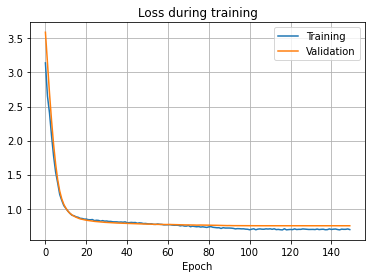

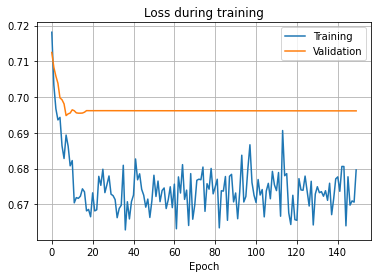

In [49]:
display_history(histories[model_nno])
display_history(histories[model_obj])

#### From the data we can infer the epoch that allowed the model to generalize better by inspecting the loss on data that it had never seen before (data on the validation set).

In [56]:
models = [model_nno, model_obj]
for model_idx in range(len(models)):
    print(f'Model {model_idx + 1} currently uses the weights that have been determined on epoch {np.argmin(histories[models[model_idx]].history["val_loss"]) + 1}.')

Model 1 currently uses the weights that have been determined on epoch 95.
Model 2 currently uses the weights that have been determined on epoch 8.


#### Small inspection of the performance of the networks:
#### Considering we had scarcely any records that could be used to train our data, we don't expect good performances. We just aim to be, at least, better than a random classifier. Furthermore, the distribution of the classes is heavily unbalanced, meaning that it does not resemble an uniform distribution at all.

#### The following classification reports sum up the performances of the trained networks with respect to the test data.

In [83]:
for i in range(len(models)):
    print(f'Classification report for the Model {i+1}:')    
    y_true = ds_splits[models[i]]['y_test']
    y_pred = np.argmax(models[i].predict(ds_splits[models[i]]['x_test']).logits,axis=-1)
    print(classification_report(y_true, y_pred, zero_division = 0))

Classification report for the Model 1:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.56      0.20      0.29        25
           2       0.71      0.94      0.81        66

    accuracy                           0.70        96
   macro avg       0.42      0.38      0.37        96
weighted avg       0.63      0.70      0.63        96

Classification report for the Model 2:
              precision    recall  f1-score   support

           0       0.61      0.77      0.68        35
           1       0.50      0.32      0.39        25

    accuracy                           0.58        60
   macro avg       0.56      0.55      0.54        60
weighted avg       0.57      0.58      0.56        60



#### The averages of the f1-score prove that the model performs slighly better than a random classifier. The performances make sense considering that only few records were available for training and by recalling the distribution of the classes in the provided dataset.